# POS Tagging - An Overview

To start, let us analyze a little about sentence composition. Have you ever stopped to think how we structure phrases? They are not random choices of words — you actually follow a structure when reasoning to make your phrase.

Of course, we follow cultural conventions learned from childhood, which may vary a little depending on region or background.
However, inside one language, there are commonly accepted rules about what is “correct” and what is not. For example, in English, adjectives are more commonly positioned before the noun (red flower, bright candle, colorless green ideas); verbs are words that denote actions and which have to exist in a phrase (for it to be a phrase)…
These rules are related to syntax, which according to Wikipedia “is the set of rules, principles, and processes that govern the structure of sentences”. Now, if you’re wondering, a Grammar is a superset of syntax (Grammar = syntax + phonology + morphology…), containing “all types of important rules” of a written language.

To better be able to depict these rules, it was defined that words belong to classes according to the role that they assume in the phrase. These roles are the things called “parts of speech”. Now, the number of distinct roles may vary from school to school, however, there are eight classes (controversies!!) that are generally accepted (for English). In alphabetical listing:

Adjective: beautiful, green, awesome…
Adpositions (prepositon/postposition): to, with, in…
Adverb: hardly, above, soon…
Articles: a, the, an…
Conjunction: and, but, yet…
Noun: cat, ape, apple…
Pronoun: it, he, you…
Verb (including auxiliary): to be, working, stood…

The real problem or the challenge is that the same word can have diffrent meanings in the diffrent or same sentences. 

<span class="mark">Sentence 1:</span> This is a green leaf. <br>
<span class="girk">Sentence 2:</span> I like greens in my food

In sentence 1, the role of green is as a noun whereas in sentence 2, the role of green is as an adjective. 
Thus we might not be doing POS tagging in our brain, but internally we do weigh words with respect their meaning. 

In the POS tagging we typically have access to the whole of sentence. The role that every word in that every sentence plays is both result of what preceeded the word and also what is going to follow that word. Thus we would be more comfortable in using bi-directional LSTM where we use the sentence from left to right and right to left.

<span class="mark">POS tagging or part of speech tagging</span> is the process of classifying words into their parts of speech and labelling them accordingly. The NLTK library has a number of corpora which contains words and its POS Tags. The following tables provides the information about each tag. 

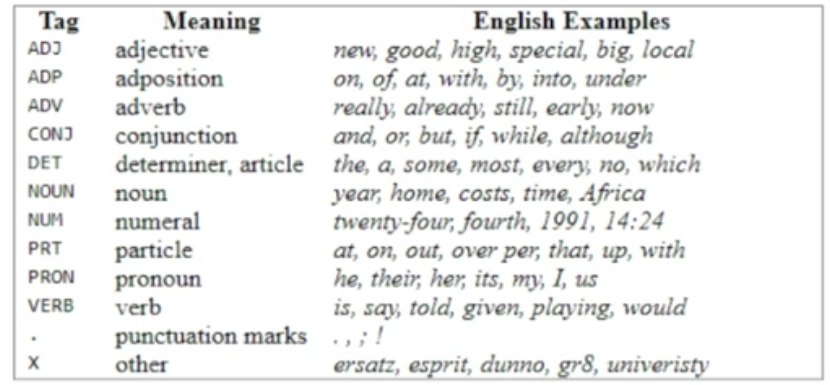

# Notebook layout
3. Preprocess data <br>
3.1  Load the Data <br>
3.2  Divide words into X and Y <br>
3.3  Vectorize X and Y <br>
3.4  Pad Sequences <br>
3.5  Word emebeddings <br>
3.6  Split the data into trainning and testing <br>


4. Vanilla RNN
4.1  Unititalized fixed embedding <br>
4.2  Unintialized trainable embedding <br>
4.3  Pre-trained embedding weights <br>


5. LSTM pre trained weights
6. GRU pre-trained weights
7. Bi-directional pre-trainable
8. Model Evaluation

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np

from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model  - # Model is at top in hiearchy then it has layers. 
# Thus we can construct any model with the help of these layers.
from tensorflow.keras.layers import Embedding, Dense, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Preprocess data

## Load data
<span class="mark">tagged_sents(tageset='universal')</span> means select all the sentence from all the genres. We do not want specific sentences from news indistry and etc. 

In [2]:
<div class="girk">
# from nltk.corpus import brown
# from nltk.corpus import treebank
# from nltk.corpus import conll2000

import nltk
nltk.download('treebank')
nltk.download('brown')
nltk.download('conll2000')
nltk.download('universal_tagset')

# load POS tagged corpora from NLTK
treebank_corpus = treebank.tagged_sents(tagset='universal')
brown_corpus = brown.tagged_sents(tagset='universal') 
conll_corpus = conll2000.tagged_sents(tagset='universal')
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/nanditapuri/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /Users/nanditapuri/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/nanditapuri/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/nanditapuri/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [3]:
# let's look at the data
tagged_sentences[11]

[('``', '.'),
 ('We', 'PRON'),
 ('have', 'VERB'),
 ('no', 'DET'),
 ('useful', 'ADJ'),
 ('information', 'NOUN'),
 ('on', 'ADP'),
 ('whether', 'ADP'),
 ('users', 'NOUN'),
 ('are', 'VERB'),
 ('at', 'ADP'),
 ('risk', 'NOUN'),
 (',', '.'),
 ("''", '.'),
 ('said', 'VERB'),
 ('*T*-1', 'X'),
 ('James', 'NOUN'),
 ('A.', 'NOUN'),
 ('Talcott', 'NOUN'),
 ('of', 'ADP'),
 ('Boston', 'NOUN'),
 ("'s", 'PRT'),
 ('Dana-Farber', 'NOUN'),
 ('Cancer', 'NOUN'),
 ('Institute', 'NOUN'),
 ('.', '.')]

## Divide data in words (X) and tags (Y)

Since this is a **many-to-many** problem, each data point will be a different sentence of the corpora.

Each data point will have multiple words in the **input sequence**. This is what we will refer to as **X**.

Each word will have its correpsonding tag in the **output sequence**. This what we will refer to as **Y**.

Sample dataset:

|                    X                        |                 Y                |
|---------------------------------------------|----------------------------------|
|   Mr. Vinken is chairman of Elsevier        |   NOUN NOUN VERB NOUN ADP NOUN   |
|     We have no useful information           |      PRON VERB DET ADJ NOUN      |

We have initialized two empty containers X and Y. Then with the help of two for loops, the most inner for loop will divide the sentence into the words and its corresponding tag. This would then be transferred to the another container with the help of outer for loop. These two loops would be running in cycles for each sentence. Once it finishes each sentence, it would erase the previous and start with the new one. Thus we need another container to transfer the previous X and Y. So at the end of the for loop, we append all the X and Y to the initial initialied empty containers. 

In [4]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

    

We convert all the characters into lower case, to count the number of words and sentences. 

In [5]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))


In [6]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 72202
Vocabulary size: 59448
Total number of tags: 12


In [7]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



As we see that one each sentence is stored in X container and it's corresponding poart of speech in y container.

In [8]:
# In this many-to-many problem, the length of each input and output sequence must be the same.
# Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 18
Length of first output sequence : 18


## Vectorise X and Y

#### Encode X and Y to integer values

We'll use the Tokenizer() function from Keras library to encode text sequence to integer sequence

In [9]:
pip install tokenizer

Note: you may need to restart the kernel to use updated packages.


A <span class="girk">tokenizer</span> receives a stream of characters, breaks it up into individual tokens (usually individual words), and outputs a stream of tokens. For instance, a whitespace tokenizer breaks text into tokens whenever it sees any whitespace. It would convert the text "Quick brown fox!" into the terms [Quick, brown, fox!].

With Keras tokenizer, it splits the sentence into words, and converts them into their number seqeuce. 

In [10]:
# encode X
from keras.preprocessing.text import Tokenizer 
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [11]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [12]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [6423, 24231, 2, 7652, 102, 170, 2, 47, 1898, 1, 269, 17, 7, 13230, 619, 1711, 2761, 3] 

Y:  [1, 1, 3, 11, 1, 6, 3, 2, 2, 5, 1, 4, 5, 6, 1, 1, 11, 3] 



In [13]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


## Pad sequences

The next step after encoding the data is to **define the sequence lengths**. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a **hyperparameter**.

Thus we make the box plot of the number of words in a sequence, select a threshold and after/before their would be zeros. 

In [14]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


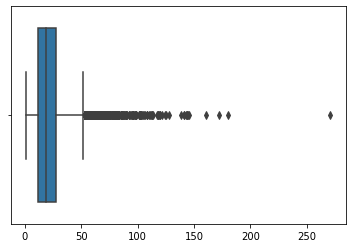

In [15]:
sns.boxplot(lengths)
plt.show()

In [16]:
# Pad each sequence to MAX_SEQ_LENGTH using KERAS' pad_sequences() function. 
# Sentences longer than MAX_SEQ_LENGTH are truncated.
# Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

# Truncation and padding can either be 'pre' or 'post'. 
# For padding we are using 'pre' padding type, that is, add zeroes on the left side.
# For truncation, we are using 'post', that is, truncate a sentence from right side.
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [17]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0  6423 24231
     2  7652   102   170     2    47  1898     1   269    17     7 13230
   619  1711  2761     3] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  3 11  1  6  3  2  2  5  1  4  5  6
  1  1 11  3]


RNN will learn the zero to zero mapping while training. So we don't need to worry about the padded zeroes. Please note that zero is not reserved for any word or tag, it's only reserved for padding.

In [18]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## Word embeddings

Currently, each word and each tag is encoded as an integer. 

We'll use a more sophisticated technique to represent the input words (X) using what's known as **word embeddings**.

However, to represent each tag in Y, we'll simply use **one-hot encoding** scheme since there are only 13 tags in the dataset and the LSTM will have no problems in learning its own representation of these tags.

To use word embeddings, you can go for either of the following models:
1. word2vec model: https://code.google.com/archive/p/word2vec/
2. GloVe model : https://nlp.stanford.edu/projects/glove/

We're using the word2vec model for no particular reason. Both of these are very efficient in representing words. You can try both and see which one works better.

Dimensions of a word embedding is: (VOCABULARY_SIZE, EMBEDDING_DIMENSION)

### Use word embeddings for input sequences (X)

In [19]:
# word2vec download link (Size ~ 1.5GB): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

path = '/Users/nanditapuri/Downloads/GoogleNews-vectors-negative300.bin.gz'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [20]:
# word2vec effectiveness
word2vec.most_similar(positive = ["King", "Woman"], negative = ["Man"])

[('Queen', 0.4929387867450714),
 ('Tupou_V.', 0.45174285769462585),
 ('Oprah_BFF_Gayle', 0.442213237285614),
 ('Jackson', 0.4402503967285156),
 ('NECN_Alison', 0.433128297328949),
 ('Whitfield', 0.42834725975990295),
 ('Ida_Vandross', 0.42084527015686035),
 ('prosecutor_Dan_Satterberg', 0.420758992433548),
 ('martin_Luther_King', 0.42059651017189026),
 ('Coretta_King', 0.4202733635902405)]

In [21]:
# assign word vectors from word2vec model

EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [22]:
# check embedding dimension
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (59449, 300)


In [23]:
# let's look at an embedding of a word
embedding_weights[word_tokenizer.word_index['joy']]

array([ 0.4453125 , -0.20019531,  0.20019531, -0.03149414,  0.078125  ,
       -0.390625  ,  0.13671875, -0.13867188,  0.05395508,  0.10546875,
       -0.05029297, -0.23730469,  0.19921875,  0.12597656, -0.12695312,
        0.34179688,  0.06347656,  0.26757812, -0.07324219, -0.29101562,
        0.10498047,  0.11914062,  0.23730469,  0.00640869,  0.12451172,
       -0.00939941, -0.02770996,  0.03076172,  0.07421875, -0.22851562,
       -0.08056641, -0.05273438,  0.16894531,  0.19824219, -0.15625   ,
       -0.08740234,  0.10742188, -0.07177734,  0.05200195,  0.25976562,
        0.171875  , -0.13574219,  0.06738281,  0.00531006,  0.15527344,
       -0.03515625,  0.08789062,  0.3359375 , -0.12890625,  0.17578125,
       -0.08642578,  0.32421875, -0.09033203,  0.35351562,  0.24316406,
       -0.07470703, -0.06640625, -0.17578125,  0.06689453, -0.03833008,
        0.0100708 , -0.21484375, -0.03686523,  0.04394531,  0.02209473,
        0.00219727, -0.22460938,  0.03015137, -0.21582031,  0.16

### Use one-hot encoding for output sequences (Y)

In [24]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)

In [25]:
# print Y of the first output sequqnce
print(Y.shape)

(72202, 100, 13)


## Split data in training, validation and tesing sets

In [26]:
# split entire data into training and testing sets
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [27]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [28]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (52165, 100)
Shape of output sequences: (52165, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (9206, 100)
Shape of output sequences: (9206, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (10831, 100)
Shape of output sequences: (10831, 100, 13)


Before using RNN, we must make sure the dimensions of the data are what an RNN expects. In general, an RNN expects the following shape

Shape of X:
(#samples, #timesteps, #features)

Shape of Y:
(#samples, #timesteps, #features)

![RNN tensor shape](./jupyter resources/rnn_tensor.png)

Now, there can be various variations in the shape that you use to feed an RNN depending on the type of architecture. Since the problem we're working on has a many-to-many architecture, the input and the output both include number of timesteps which is nothing but the sequence length. But notice that the tensor X doesn't have the third dimension, that is, number of features. That's because we're going to use word embeddings before feeding in the data to an RNN, and hence there is no need to explicitly mention the third dimension. That's because when you use the Embedding() layer in Keras, you the training data will automatically be converted to (#samples, #timesteps, #features) where #features will be the embedding dimention (and note that the Embedding layer is always the very first layer of an RNN). While using the embedding layer we only need to reshape the data to (#samples, #timesteps) which is what we have done. However, note that you'll need to shape it to (#samples, #timesteps, #features) in case you don't use the Embedding() layer in Keras.

# 2. Vanilla RNN

### Uninitialised fixed embeddings
First let's try running a vanilla RNN. For this RNN we won't use the pre-trained word embeddings. We'll use randomly inititalised embeddings. Moreover, we won't update the embeddings weights.

In [29]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [30]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  False                    # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [31]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [32]:
# check summary of the model
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          17834700  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           23360     
                                                                 
 time_distributed (TimeDistr  (None, 100, 13)          845       
 ibuted)                                                         
                                                                 
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


## Fit model

In [33]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 24s 56ms/step - loss: 0.5256 - acc: 0.8505 - val_loss: 0.3543 - val_acc: 0.8937
Epoch 2/10
408/408 [==============================] - 25s 61ms/step - loss: 0.2974 - acc: 0.9104 - val_loss: 0.2481 - val_acc: 0.9242
Epoch 3/10
408/408 [==============================] - 24s 58ms/step - loss: 0.2236 - acc: 0.9308 - val_loss: 0.2004 - val_acc: 0.9364
Epoch 4/10
408/408 [==============================] - 24s 58ms/step - loss: 0.1873 - acc: 0.9404 - val_loss: 0.1733 - val_acc: 0.9439
Epoch 5/10
408/408 [==============================] - 22s 55ms/step - loss: 0.1653 - acc: 0.9466 - val_loss: 0.1558 - val_acc: 0.9490
Epoch 6/10
408/408 [==============================] - 22s 53ms/step - loss: 0.1515 - acc: 0.9503 - val_loss: 0.1450 - val_acc: 0.9521
Epoch 7/10
408/408 [==============================] - 22s 55ms/step - loss: 0.1420 - acc: 0.9528 - val_loss: 0.1373 - val_acc: 0.9542
Epoch 8/10
408/408 [==============================] - 22s 54ms

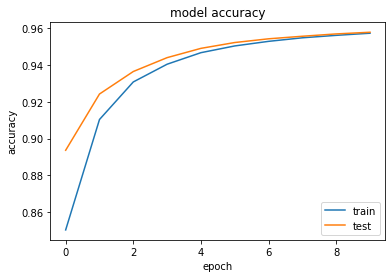

In [34]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In the model accuracy we see that the trainning accuracy starts from 85% from the first first epoch and it later increased with subsequent epochs. But with testing accuracy we see that after receiving the model architecture and weights, it starts from 90% accuracy itself and increases with the number of epochs.

### Uninitialised trainable embeddings

In [35]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [36]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [37]:
# check summary of the model
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [38]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 94s 229ms/step - loss: 0.2208 - acc: 0.9473 - val_loss: 0.0420 - val_acc: 0.9876
Epoch 2/10
408/408 [==============================] - 94s 230ms/step - loss: 0.0301 - acc: 0.9903 - val_loss: 0.0297 - val_acc: 0.9897
Epoch 3/10
408/408 [==============================] - 95s 232ms/step - loss: 0.0209 - acc: 0.9927 - val_loss: 0.0274 - val_acc: 0.9903
Epoch 4/10
408/408 [==============================] - 91s 222ms/step - loss: 0.0173 - acc: 0.9939 - val_loss: 0.0271 - val_acc: 0.9904
Epoch 5/10
408/408 [==============================] - 94s 230ms/step - loss: 0.0150 - acc: 0.9947 - val_loss: 0.0275 - val_acc: 0.9903
Epoch 6/10
408/408 [==============================] - 91s 223ms/step - loss: 0.0131 - acc: 0.9955 - val_loss: 0.0280 - val_acc: 0.9904
Epoch 7/10
408/408 [==============================] - 92s 225ms/step - loss: 0.0113 - acc: 0.9961 - val_loss: 0.0297 - val_acc: 0.9901
Epoch 8/10
408/408 [==============================] - 9

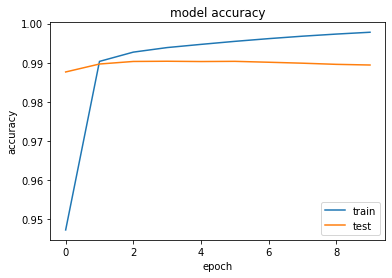

In [39]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In the trainned embedding, we see that the trainning accuracy itself starts from 95% but the testing accuracy is so high that from 0th epoch it starts from 99%.

### Using pre-trained embedding weights

In [40]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        weights       = [embedding_weights],      # word embedding matrix
                        trainable     =  True                     # True - update the embeddings while training
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [41]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [42]:
# check summary of the model
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           23360     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,858,905
Trainable params: 17,858,905
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [43]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 94s 229ms/step - loss: 0.1824 - acc: 0.9626 - val_loss: 0.0346 - val_acc: 0.9891
Epoch 2/10
408/408 [==============================] - 92s 226ms/step - loss: 0.0267 - acc: 0.9910 - val_loss: 0.0269 - val_acc: 0.9906
Epoch 3/10
408/408 [==============================] - 93s 229ms/step - loss: 0.0199 - acc: 0.9930 - val_loss: 0.0253 - val_acc: 0.9910
Epoch 4/10
408/408 [==============================] - 93s 228ms/step - loss: 0.0169 - acc: 0.9939 - val_loss: 0.0248 - val_acc: 0.9911
Epoch 5/10
408/408 [==============================] - 93s 227ms/step - loss: 0.0149 - acc: 0.9947 - val_loss: 0.0249 - val_acc: 0.9913
Epoch 6/10
408/408 [==============================] - 94s 230ms/step - loss: 0.0131 - acc: 0.9954 - val_loss: 0.0257 - val_acc: 0.9911
Epoch 7/10
408/408 [==============================] - 96s 236ms/step - loss: 0.0115 - acc: 0.9960 - val_loss: 0.0267 - val_acc: 0.9909
Epoch 8/10
408/408 [==============================] - 9

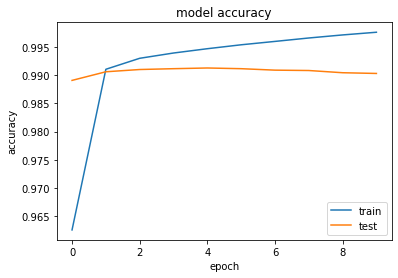

In [44]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Trainable weights and pre-trained weights did not have much diffrence. The test accuracy is more or less the same.

# 2. LSTM

We'll use pre-trained word embeddings in following models and allow them to be updated as well. 

## Create model architecture

In [45]:
# create architecture

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                         output_dim    = EMBEDDING_SIZE,          # length of vector with which each word is represented
                         input_length  = MAX_SEQ_LENGTH,          # length of input sequence
                         weights       = [embedding_weights],     # word embedding matrix
                         trainable     = True                     # True - update embeddings_weight matrix
))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [46]:
lstm_model.compile(loss      =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])

In [47]:
# check summary of the model
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 lstm (LSTM)                 (None, 100, 64)           93440     
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,928,985
Trainable params: 17,928,985
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [48]:
lstm_training = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 114s 275ms/step - loss: 0.3095 - acc: 0.9292 - val_loss: 0.0478 - val_acc: 0.9872
Epoch 2/10
408/408 [==============================] - 109s 267ms/step - loss: 0.0340 - acc: 0.9895 - val_loss: 0.0297 - val_acc: 0.9899
Epoch 3/10
408/408 [==============================] - 110s 269ms/step - loss: 0.0236 - acc: 0.9917 - val_loss: 0.0263 - val_acc: 0.9906
Epoch 4/10
408/408 [==============================] - 110s 269ms/step - loss: 0.0199 - acc: 0.9928 - val_loss: 0.0251 - val_acc: 0.9910
Epoch 5/10
408/408 [==============================] - 109s 267ms/step - loss: 0.0178 - acc: 0.9934 - val_loss: 0.0245 - val_acc: 0.9912
Epoch 6/10
408/408 [==============================] - 111s 272ms/step - loss: 0.0163 - acc: 0.9940 - val_loss: 0.0243 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 110s 269ms/step - loss: 0.0148 - acc: 0.9946 - val_loss: 0.0241 - val_acc: 0.9916
Epoch 8/10
408/408 [============================

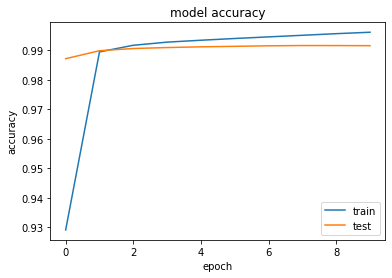

In [49]:
# visualise training history
plt.plot(lstm_training.history['acc'])
plt.plot(lstm_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

Even though the trainning accuracy was growing from 0 to 2 epoch, the testing accuracy started from the same point at 0 epochs where other vanilla RNN's did.

# 2. GRU

## Create model architecture

In [50]:
# create architecture

gru_model = Sequential()
gru_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                        output_dim    = EMBEDDING_SIZE,
                        input_length  = MAX_SEQ_LENGTH,
                        weights       = [embedding_weights],
                        trainable     = True
))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [51]:
gru_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [52]:
# check summary of model
gru_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 gru (GRU)                   (None, 100, 64)           70272     
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 17,905,817
Trainable params: 17,905,817
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [53]:
gru_training = gru_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 108s 256ms/step - loss: 0.2217 - acc: 0.9611 - val_loss: 0.0351 - val_acc: 0.9885
Epoch 2/10
408/408 [==============================] - 104s 254ms/step - loss: 0.0275 - acc: 0.9904 - val_loss: 0.0270 - val_acc: 0.9903
Epoch 3/10
408/408 [==============================] - 103s 253ms/step - loss: 0.0209 - acc: 0.9924 - val_loss: 0.0250 - val_acc: 0.9909
Epoch 4/10
408/408 [==============================] - 104s 254ms/step - loss: 0.0181 - acc: 0.9932 - val_loss: 0.0242 - val_acc: 0.9911
Epoch 5/10
408/408 [==============================] - 107s 262ms/step - loss: 0.0164 - acc: 0.9938 - val_loss: 0.0239 - val_acc: 0.9913
Epoch 6/10
408/408 [==============================] - 107s 263ms/step - loss: 0.0151 - acc: 0.9943 - val_loss: 0.0240 - val_acc: 0.9914
Epoch 7/10
408/408 [==============================] - 108s 266ms/step - loss: 0.0139 - acc: 0.9948 - val_loss: 0.0241 - val_acc: 0.9915
Epoch 8/10
408/408 [============================

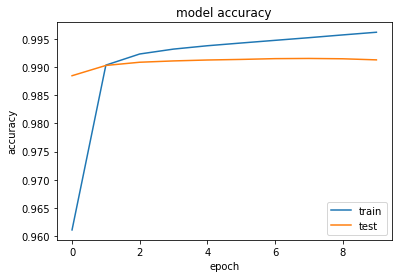

In [54]:
# visualise training history
plt.plot(gru_training.history['acc'])
plt.plot(gru_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

The trainning accuracy reached to about 100% but the testing accuracy remained stagnant to 99% like other vanilla RNN.

# 3. Bidirectional LSTM

## Create model architecture

In [55]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

## Compile model

In [56]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [57]:
# check summary of model
bidirect_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          17834700  
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         186880    
 l)                                                              
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 18,023,257
Trainable params: 18,023,257
Non-trainable params: 0
_________________________________________________________________


## Fit model

In [59]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
408/408 [==============================] - 137s 337ms/step - loss: 0.0136 - acc: 0.9955 - val_loss: 0.0184 - val_acc: 0.9938
Epoch 2/10
408/408 [==============================] - 142s 348ms/step - loss: 0.0108 - acc: 0.9964 - val_loss: 0.0178 - val_acc: 0.9940
Epoch 3/10
408/408 [==============================] - 145s 355ms/step - loss: 0.0088 - acc: 0.9971 - val_loss: 0.0178 - val_acc: 0.9941
Epoch 4/10
408/408 [==============================] - 146s 359ms/step - loss: 0.0071 - acc: 0.9977 - val_loss: 0.0181 - val_acc: 0.9941
Epoch 5/10
408/408 [==============================] - 146s 358ms/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.0190 - val_acc: 0.9941
Epoch 6/10
408/408 [==============================] - 146s 358ms/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0203 - val_acc: 0.9939
Epoch 7/10
408/408 [==============================] - 148s 362ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.0214 - val_acc: 0.9939
Epoch 8/10
408/408 [============================

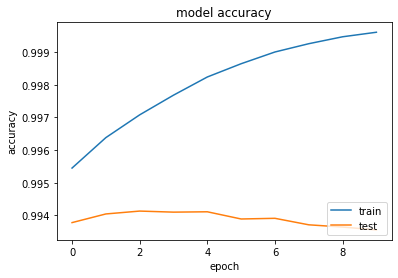

In [60]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

We see a huge gap between trainning accuracy and testing accuracy. It looks like an overfitting, but isn't as the accuracy measures considered are way too low.

# 5. Model evaluation

In [61]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 3s 10ms/step - loss: 0.0317 - acc: 0.9904
Loss: 0.0316857285797596,
Accuracy: 0.9903545379638672


In [62]:
loss, accuracy = lstm_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 5s 14ms/step - loss: 0.0250 - acc: 0.9916
Loss: 0.02499561570584774,
Accuracy: 0.9916480183601379


In [63]:
loss, accuracy = gru_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 4s 12ms/step - loss: 0.0260 - acc: 0.9914
Loss: 0.026019984856247902,
Accuracy: 0.9914255142211914


In [64]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

339/339 [==============================] - 8s 23ms/step - loss: 0.0261 - acc: 0.9936
Loss: 0.026056235656142235,
Accuracy: 0.9936146140098572


Thus the bidirectional model has the largest accuracy out of all.